# Decision Trees, Random Forest and Extra Trees
The goal of this project as explained before, is to create an a model to classify AppleWatch for Galaxy Watch subreddits based on their posts. To achieve this, here, we will work on three models:

- Decision Trees with Bagging
- Random Forest 
- and Extra Trees

We have chosen to employ bagging and random forests for ensembling because single decision trees are prone to overfitting, and ensembling helps mitigate this issue. 
To transform and vectorize the post texts, we will experiment with two techniques: count vectorizer and TF-IDF vectorizer. These techniques will allow us to convert the text data into numerical features that can be used for modeling.
After vectorizing the data, we will evaluate the models using classification metrics such as accuracy, recall (sensitivity), precision, and specificity. Our goal is to determine which model performs the best based on these metrics.

To streamline the implementation process and incorporate the vectorization and classification steps seamlessly, we will utilize pipelines. This approach will enable us to easily instantiate and execute the models with the chosen vectorization technique. In order to find the optimal parameters for each model, we will utilize grid search. This technique will systematically explore different combinations of parameters to identify the configuration that yields the highest performance.

At the conclusion of each modeling approach, particularly for random forest and extra trees, we will analyze the feature importance. This analysis will provide insights into the weight assigned to each feature in classifying the subreddits. By understanding the feature importance, we can determine which features have a greater influence on the classification process and gain valuable insights.

## Imports

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [2]:
# Define dataframe path
df_path = "../data/final_dataset.csv"

In [3]:
# load data
df = pd.read_csv(df_path).drop(columns="Unnamed: 0")

# Get some basic information 
print(f"Sample Data :{df.head()}")
print(f"\n--------------------------\n\n Columns : {[i for i in df.columns]}")
print(f"\n--------------------------\n\n Size of the dataset : {df.shape[0]}")
print(f"\n--------------------------\n\n Total number of columns : {df.shape[1]}")

Sample Data :            author                                        description  \
0          TuaAnon  yes, it's an lte watch with data turned on, no...   
1  DemandScary1934  how accurate is the active/total calorie track...   
2         Vinumite  fell very hard blackout drunk and lost watch. ...   
3          Damarou  pls tell me i‘m not the only one who has such ...   
4       ThorNike13  deleted apps in watch app on iphone with weird...   

    subreddit  des_word_count  
0  AppleWatch              48  
1  AppleWatch              10  
2  AppleWatch              59  
3  AppleWatch              15  
4  AppleWatch              15  

--------------------------

 Columns : ['author', 'description', 'subreddit', 'des_word_count']

--------------------------

 Size of the dataset : 5270

--------------------------

 Total number of columns : 4


In [4]:
# Drop unusefull columns
df.drop(columns =["author", "des_word_count"], inplace=True)

In [5]:
# Create label column (target column)
df["subreddit"] = df["subreddit"].map({"GalaxyWatch": 1, "AppleWatch":0})

## Functions

In [6]:
# cite: Got help form Katie Sylvia
# a function for stemming
def stem_words(text):
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    
    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Stem each word and join them back into a string
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = " ".join(stemmed_words)
    
    return stemmed_text

In [7]:
# Grid search over with pipeline estimator
def gridsearching(estimator, param_grid, model_name, transformer_name):
    
    print(f" Summary of {model_name} Model with {transformer_name} Transformer Evaluation ".center(115, "="))
    
    # Instantiate a GridSearch model
    gs = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, n_jobs=5)

    # Fit the model to traning data
    gs.fit(X_train, y_train)

    # Get to know wich params were the best ones
    print(" The Best Params ".center(34, "="))
    print(gs.best_params_)
    print()

    # Get to know the best score
    print(" The Best Score ".center(34, "="))
    print(gs.best_score_)
    print()

    # Train data score
    print(" Train Score ".center(34, "="))
    print(gs.score(X_train, y_train))
    print()

    # Test data score
    print(" Test Score ".center(34, "="))
    print(gs.score(X_test, y_test))
    
    # Get predictions
    preds = gs.predict(X_test)

    # Confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # Confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap="Purples", values_format="d")

    plt.title(f"The Confusion Matrix of {model_name} with {transformer_name}");

    # Evaluate a model
    print(f" Evaluation Metrics ".center(34, "="))
    print(f"Accuracy  ---------- {accuracy_score(y_test, preds)}")
    print(f"Precision  --------- {precision_score(y_test, preds)}")
    print(f"Sensitivity  ------- {recall_score(y_test, preds)}")
    print(f"Specifity  --------- {tn/(tn + fp)}")

In [8]:
# Cite: Got that function from GA 603-lesson_random_forest (Katie Sylvia)
def plot_feature_importance(importance, names, model_type):


    # Create a DataFrame using a Dictionary
    df = pd.DataFrame({"feature_names":names,
                       "feature_importance":importance})

    # Sort the DataFrame in order decreasing feature importance
    df.sort_values(by=["feature_importance"], ascending=False,inplace=True)
    top_features = df.head(20)

    # Define size of bar plot
    plt.figure(figsize=(10,8))
    
    # Generate a color palette based on the volume of feature importances
    palette = sns.color_palette("Purples", len(top_features))
    
    # Reverse the color palette
    reversed_palette = palette[::-1]
    
    # Plot Searborn bar chart
    sns.barplot(x=top_features["feature_importance"], y=top_features["feature_names"], palette=reversed_palette)
    
    # Add chart labels
    plt.title(model_type +  " Feature Importance", fontsize=14)
    plt.xlabel("Feature Importance", fontsize=12)
    plt.ylabel("Feature Names", fontsize=12)
    

## Baseline Score

In [9]:
# Define X (features) and y(target)
X = df["description"]
y = df["subreddit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(f"X shape ---------- {X.shape}")
print(f"y shape ---------- {y.shape}")

X shape ---------- (5270,)
y shape ---------- (5270,)


### Baseline accuracy

In [10]:
# Get the ratio of classes
y_test.value_counts(normalize=True)

0    0.534143
1    0.465857
Name: subreddit, dtype: float64

**Baseline accuracy score is 0.53 which is the majority class**

## Decision Tree Model

### Decision Tree with CountVectorizer

In [ ]:
# Instantiate Decision Tree
tree = DecisionTreeClassifier()

In [12]:
# Instantiate the pipeline with Bagged Decision Tree and CountVectorizer transformer
pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("bg", BaggingClassifier(tree))
])

In [13]:
# Get pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('bg', BaggingClassifier(base_estimator=DecisionTreeClassifier()))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'bg': BaggingClassifier(base_estimator=DecisionTreeClassifier()),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'bg__base_estimator__ccp_alpha': 0.0,
 'bg__base_estimator__class_weight': None,
 'bg__base_estimator__criterion': 'gini',
 'bg__base_estimator__max_depth': None,
 'bg__base_estimator__max_features': None,
 'bg__base_estimator__max_leaf_nodes': None,
 'bg__base_estimator__min_i

In [14]:
# Set pipeline params by cvec
pipe_params = {
    "cvec__tokenizer": [None, stem_words],
    "cvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "cvec__min_df": [2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__stop_words": [None, "english"],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "bg__base_estimator__max_depth": [None, 1, 2, 3, 4],
    "bg__n_estimators": [100]
}

==================== Summary of Decision Tree Model with CountVectorizer Transformer Evaluation ===================
======== The Best Params =========
{'bg__base_estimator__max_depth': None, 'bg__n_estimators': 100, 'cvec__max_df': 0.9, 'cvec__max_features': 30000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'cvec__tokenizer': None}

========= The Best Score =========
0.8711987709836931

========== Train Score ===========
0.9992408906882592

=========== Test Score ===========
0.8763277693474962


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.8763277693474962
Precision  --------- 0.893542757417103
Sensitivity  ------- 0.8338762214983714
Specifity  --------- 0.9133522727272727


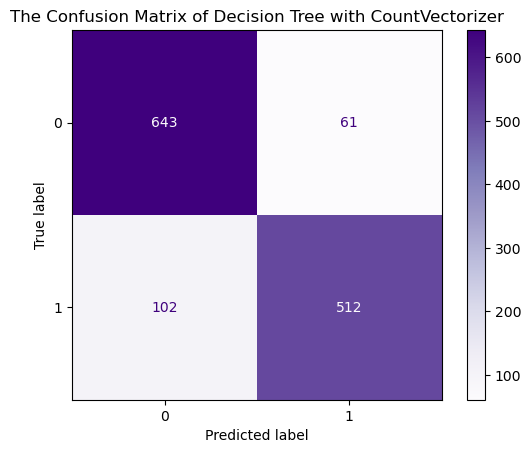

In [15]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe, param_grid=pipe_params, model_name="Decision Tree", transformer_name="CountVectorizer")

### Decision Tree with TfidVectorizer

In [16]:
# Instantiate Decision Tree
tree = DecisionTreeClassifier()

In [17]:
# Instantiate the pipeline with Bagged Decision Tree and TfidVectorizer transformer
pipe_tvec = Pipeline([
    ("tvec", TfidfVectorizer()),
    ("bg", BaggingClassifier(tree))
])

In [18]:
# Get pipeline params
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()),
  ('bg', BaggingClassifier(base_estimator=DecisionTreeClassifier()))],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'bg': BaggingClassifier(base_estimator=DecisionTreeClassifier()),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'bg__base_estimator__ccp_alpha': 0.0,
 'bg__base_estimator__class_weight': None,
 'bg__base_estimator__criterion': 'gini',
 'bg__base_estimator__max_depth': None,
 'bg__base_

In [19]:
# Set pipeline params by cvec
pipe_tvec_params = {
    "tvec__tokenizer": [None, stem_words],
    "tvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "tvec__min_df": [2, 3],
    "tvec__max_df": [.9, .95],
    "tvec__stop_words": [None, "english"],
    "tvec__ngram_range": [(1, 1), (1, 2)],
    "bg__base_estimator__max_depth": [None, 1, 2, 3, 4],
    "bg__n_estimators": [100]
}

==================== Summary of Decision Tree Model with TfidVectorizer Transformer Evaluation ====================
======== The Best Params =========
{'bg__base_estimator__max_depth': None, 'bg__n_estimators': 100, 'tvec__max_df': 0.9, 'tvec__max_features': 20000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english', 'tvec__tokenizer': None}

========= The Best Score =========
0.8676579878058538

========== Train Score ===========
0.9979757085020243

=========== Test Score ===========
0.870257966616085


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.870257966616085
Precision  --------- 0.8760611205432938
Sensitivity  ------- 0.8403908794788274
Specifity  --------- 0.8963068181818182


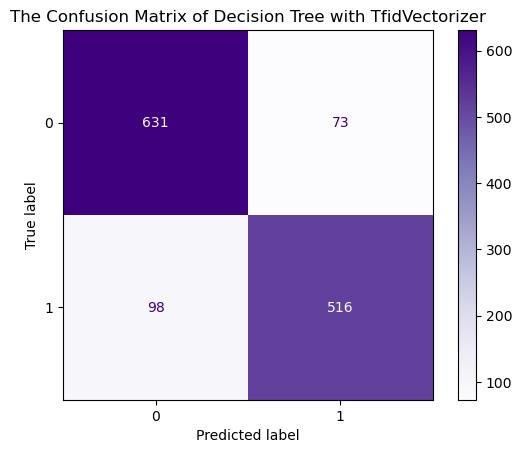

In [20]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe_tvec, param_grid=pipe_tvec_params, model_name="Decision Tree", transformer_name="TfidVectorizer")

## Random Forest Model

### Random Forest with CountVectorizer

In [21]:
# Instantiate the pipeline with Random Forest and countvectorizer transformer
pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("rf", RandomForestClassifier())
])

In [22]:
# Get pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_est

In [23]:
# Set pipeline params by cvec
pipe_params = {
    "cvec__tokenizer": [None, stem_words],
    "cvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "cvec__min_df": [2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__stop_words": [None, "english"],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "rf__max_depth": [None, 1, 2, 3, 4],
    "rf__n_estimators": [100]
}

==================== Summary of Random Forest Model with CountVectorizer Transformer Evaluation ===================
======== The Best Params =========
{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'cvec__tokenizer': None, 'rf__max_depth': None, 'rf__n_estimators': 100}

========= The Best Score =========
0.8944825489286113

========== Train Score ===========
0.9984817813765182

=========== Test Score ===========
0.8930197268588771


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.8930197268588771
Precision  --------- 0.8948247078464107
Sensitivity  ------- 0.8729641693811075
Specifity  --------- 0.9105113636363636


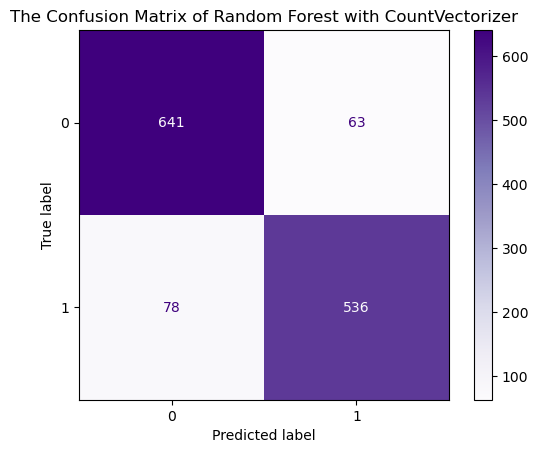

In [24]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe, param_grid=pipe_params, model_name="Random Forest", transformer_name="CountVectorizer")

### Feature Importance with Random Forest and CountVectorizer Transformer

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


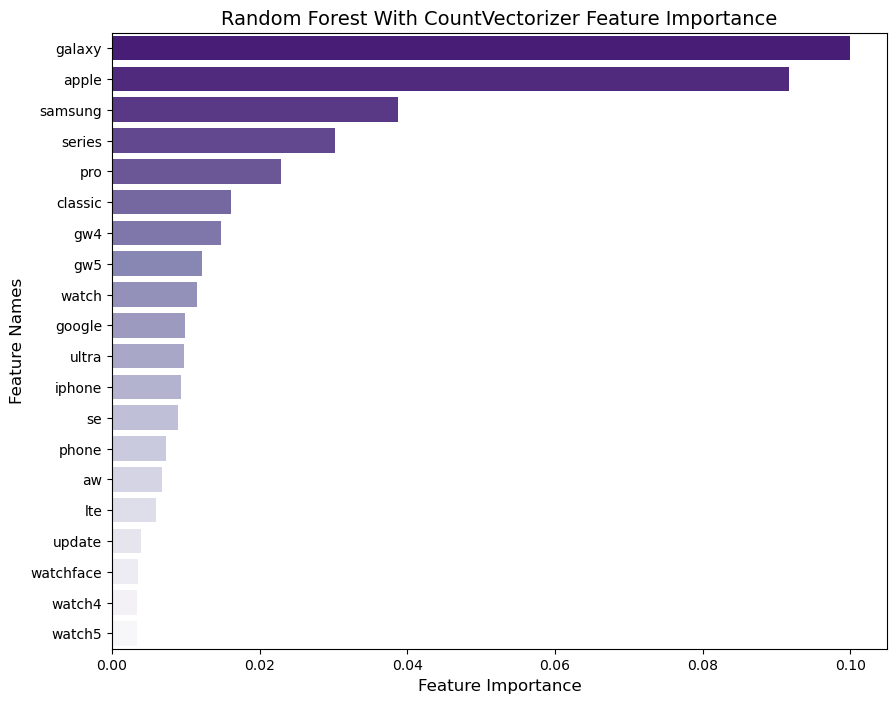

In [60]:
# Instantiate Countvectorizer with best params 
cvec = CountVectorizer(max_df=0.9, max_features=5000, min_df=2, ngram_range=(1,1),
                       stop_words="english", tokenizer=None)

# Fit and transform train data with countvectorizer
X_train_cvec = cvec.fit_transform(X_train)

# Transform test data with countvectorizer
X_test_cvec = cvec.transform(X_test)

# Instantiate Random Forest and fit the model with best params
rf_cvec = RandomForestClassifier(max_depth=None, n_estimators=100)
rf_cvec.fit(X_train_cvec, y_train)

# Make a train dataframe based on transformed data
X_train_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                          columns=cvec.get_feature_names())

# Plot top 20 features
plot_feature_importance(rf_cvec.feature_importances_, X_train_df.columns,"Random Forest With CountVectorizer")

### Random Forest with TfidVectorizer

In [26]:
# Redifine training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [27]:
# Instantiate the pipeline with Random Forest and Tfidfvectorizer transformer
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [28]:
# Get pipeline params
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'rf': RandomForestClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 '

In [29]:
# Set pipeline params by tvec
pipe_tvec_params = {
    'tvec__tokenizer': [None, stem_words],
    'tvec__max_features': [5_000, 10_000, 20_000, 30_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'rf__max_depth': [None, 1, 2, 3, 4],
    'rf__n_estimators': [100]
}

==================== Summary of Random Forest Model with TfidfVectorizer Transformer Evaluation ===================
======== The Best Params =========
{'rf__max_depth': None, 'rf__n_estimators': 100, 'tvec__max_df': 0.95, 'tvec__max_features': 30000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english', 'tvec__tokenizer': None}

========= The Best Score =========
0.8929616412488597

========== Train Score ===========
0.9984817813765182

=========== Test Score ===========
0.8983308042488619


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.8983308042488619
Precision  --------- 0.9240282685512368
Sensitivity  ------- 0.8517915309446255
Specifity  --------- 0.9389204545454546


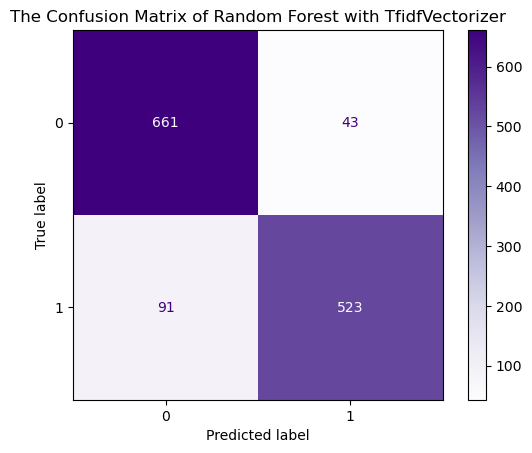

In [30]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe_tvec, param_grid=pipe_tvec_params, model_name="Random Forest", transformer_name="TfidfVectorizer")

### Feature Importance with Random Forest and TfidVectorizer Transformer

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


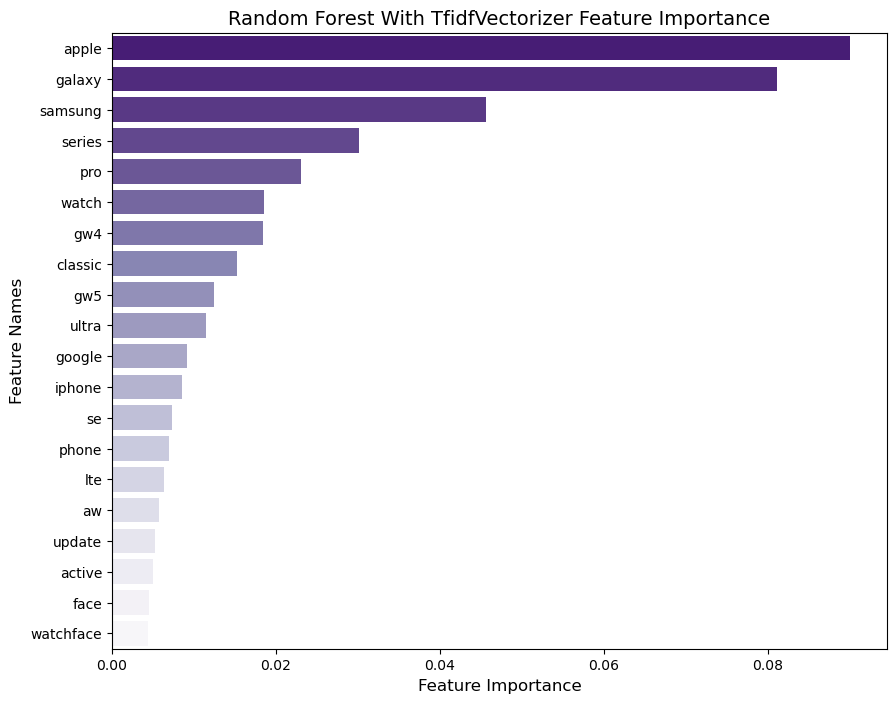

In [57]:
# Instantiate TfidfVectorizer with best params 
tvec = TfidfVectorizer(max_df=0.95, max_features=30000, min_df=2, ngram_range=(1,1),
                       stop_words="english", tokenizer=None)

# Fit and transform train data with TfidfVectorizer
X_train_tvec = tvec.fit_transform(X_train)

# Transform test data with TfidfVectorizer
X_test_tvec = tvec.transform(X_test)

# Instantiate Random Forest and fit the model with best params
rf_tvec = RandomForestClassifier(max_depth=None, n_estimators=100)
rf_tvec.fit(X_train_tvec, y_train)

# Make a train dataframe based on transformed data
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

# Plot top 20 features
plot_feature_importance(rf_tvec.feature_importances_, X_train_df.columns,"Random Forest With TfidfVectorizer")

## Extra Trees Model

### Extra Trees with CountVectorizer

In [35]:
# Instantiate the pipeline with Extra Trees and countvectorizer transformer
pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("et", ExtraTreesClassifier())
])

In [36]:
# Get pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('et', ExtraTreesClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'et': ExtraTreesClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'et__bootstrap': False,
 'et__ccp_alpha': 0.0,
 'et__class_weight': None,
 'et__criterion': 'gini',
 'et__max_depth': None,
 'et__max_features': 'auto',
 'et__max_leaf_nodes': None,
 'et__max_samples': None,
 'et__min_impurity_decrease': 0.0,
 'et__min_samples_leaf': 1,
 'et__min_samples_split': 2,
 'et__min_weight_fraction_leaf': 0.0,
 'et__n_estima

In [37]:
# Set pipeline params by cvec
pipe_params = {
    "cvec__tokenizer": [None, stem_words],
    "cvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "cvec__min_df": [2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__stop_words": [None, "english"],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "et__max_depth": [None, 1, 2, 3, 4],
    "et__n_estimators": [100]
}

===================== Summary of Extra Trees Model with CountVectorizer Transformer Evaluation ====================
======== The Best Params =========
{'cvec__max_df': 0.95, 'cvec__max_features': 30000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__tokenizer': None, 'et__max_depth': None, 'et__n_estimators': 100}

========= The Best Score =========
0.8970106738786028

========== Train Score ===========
0.9989878542510121

=========== Test Score ===========
0.8937784522003035


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.8937784522003035
Precision  --------- 0.9003378378378378
Sensitivity  ------- 0.8680781758957655
Specifity  --------- 0.9161931818181818


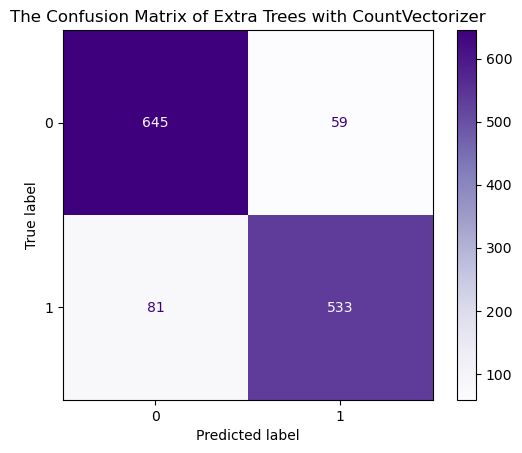

In [38]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe, param_grid=pipe_params, model_name="Extra Trees", transformer_name="CountVectorizer")

### Feature Importance with Extra Trees and CountVectorizer Transformer

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


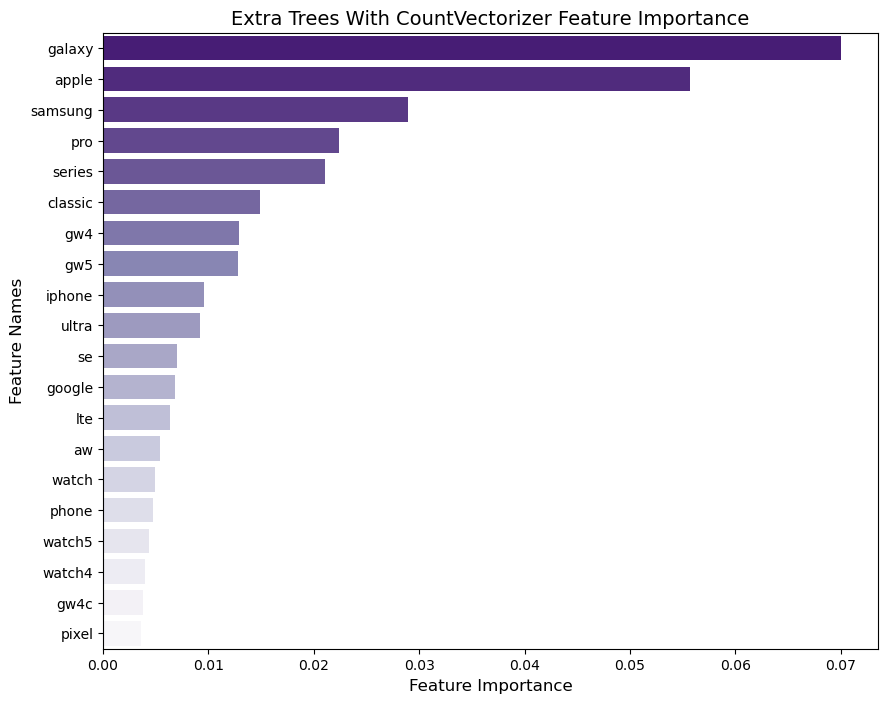

In [39]:
# Instantiate Countvectorizer with best params 
cvec = CountVectorizer(max_df=0.95, max_features=30000, min_df=3, ngram_range=(1,1),
                       stop_words=None, tokenizer=None)

# Fit and transform train data with countvectorizer
X_train_cvec = cvec.fit_transform(X_train)

# Transform test data with countvectorizer
X_test_cvec = cvec.transform(X_test)

# Instantiate Extra Trees and fit the model with best params
et_cvec = ExtraTreesClassifier(max_depth=None, n_estimators=100)
et_cvec.fit(X_train_cvec, y_train)

# Make a train dataframe based on transformed data
X_train_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                          columns=cvec.get_feature_names())

# Plot top 20 features
plot_feature_importance(et_cvec.feature_importances_, X_train_df.columns,"Extra Trees With CountVectorizer")

### Extra Trees with TfidVectorizer

In [40]:
# Redifine training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [44]:
# Instantiate the pipeline with Extra Trees and Tfidfvectorizer transformer
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier())
])

In [45]:
# Get pipeline params
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('et', ExtraTreesClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'et': ExtraTreesClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'et__bootstrap': False,
 'et__ccp_alpha': 0.0,
 'et__class_weight': None,
 'et__criterion': 'gini',
 'et__max_depth': None,
 'et__max_features': 'auto',
 'et__max_leaf_nodes': None,
 'et__max_samples': None,
 'et__min_impurity_decrease': 0.0,
 'et_

In [46]:
# Set pipeline params by tvec
pipe_tvec_params = {
    'tvec__tokenizer': [None, stem_words],
    'tvec__max_features': [5_000, 10_000, 20_000, 30_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'et__max_depth': [None, 1, 2, 3, 4],
    'et__n_estimators': [100]
}

===================== Summary of Extra Trees Model with TfidfVectorizer Transformer Evaluation ====================
======== The Best Params =========
{'et__max_depth': None, 'et__n_estimators': 100, 'tvec__max_df': 0.95, 'tvec__max_features': 10000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english', 'tvec__tokenizer': None}

========= The Best Score =========
0.8970061930899839

========== Train Score ===========
0.9979757085020243

=========== Test Score ===========
0.9051593323216995


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.9051593323216995
Precision  --------- 0.9312169312169312
Sensitivity  ------- 0.8599348534201955
Specifity  --------- 0.9446022727272727


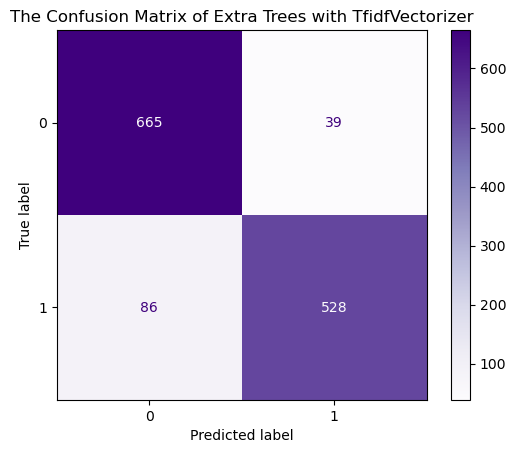

In [47]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe_tvec, param_grid=pipe_tvec_params, model_name="Extra Trees", transformer_name="TfidfVectorizer")

### Feature Importance with Extra Trees and TfidVectorizer Transformer

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


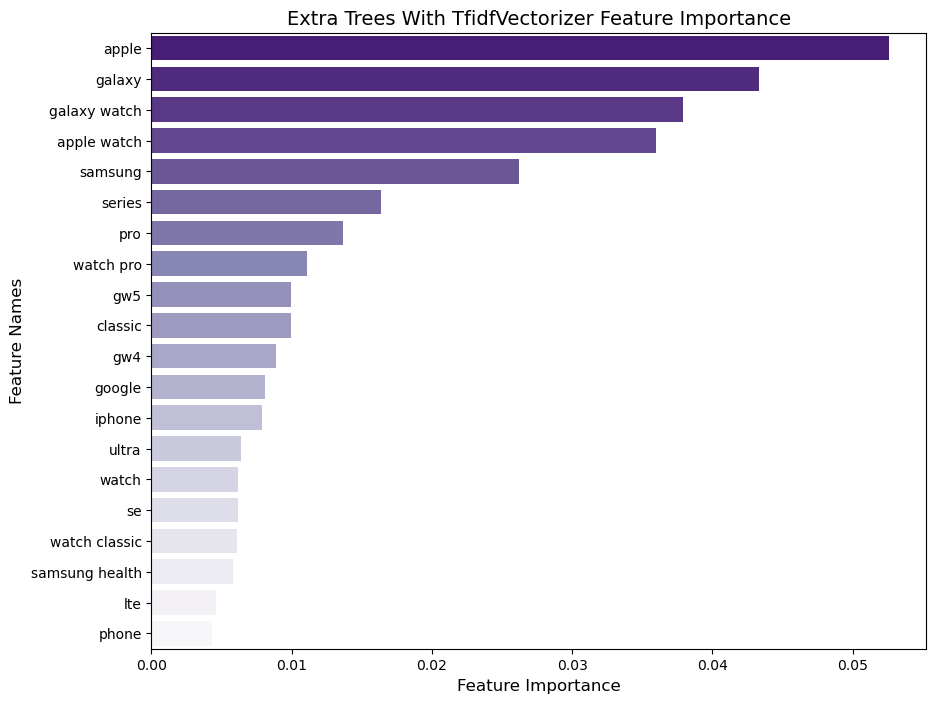

In [53]:
# Instantiate TfidfVectorizer with best params 
tvec = TfidfVectorizer(max_df=0.95, max_features=10000, min_df=3, ngram_range=(1,2),
                       stop_words="english", tokenizer=None)

# Fit and transform train data with TfidfVectorizer
X_train_tvec = tvec.fit_transform(X_train)

# Transform test data with TfidfVectorizer
X_test_tvec = tvec.transform(X_test)

# Instantiate Extra Trees and fit the model with best params
et_tvec = ExtraTreesClassifier(max_depth=None, n_estimators=100)
et_tvec.fit(X_train_tvec, y_train)

# Make a train dataframe based on transformed data
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

# Plot top 20 features
plot_feature_importance(et_tvec.feature_importances_, X_train_df.columns,"Extra Trees With TfidfVectorizer")

## Save The Best Models

In [64]:
with open("../models/rf_tvec.pkl", "wb") as pickle_out:
    pickle_out = pickle.dump(rf_tvec, pickle_out)
    
with open("../models/et_tvec.pkl", "wb") as pickle_out:
    pickle_out = pickle.dump(et_tvec, pickle_out)